# 1. Synthetic Pumping Test - Introduction

# THIS NOTEBOOK NEEDS WORK BEFORE IT IS PUBLISHED ONLINE

## Introduction

### What is `timflow.transient`?

`timflow.transient` uses the Laplace Transform Analytic Element Method (AEM) to derive a solution to transient flow in multi-layered systems. `timflow` uses discrete features such as Wells and Line-elements to represent real-world aquifer features of interest.


In this notebook we demonstrate:

* How to specify a simple conceptual model consisting of one confining layer and one well
* Simulate the model
* Calibrate aquifer parameters by providing data from observation wells

To achieve this we will create a Model, sample some observations add noise and try to find the model parameters through fitting

We begin by importing the required libraries

## Step 1: Import the Required Libraries

In [1]:
import matplotlib.pyplot as plt  # Plotting library
import numpy as np  # Numpy

from timflow import transient as tft

plt.rcParams['figure.figsize'] = (6, 4)

## Step 2: Set Model Parameters

We set the model parameters with dimensions in **meters** and time in **days**

In [2]:
H = 7  # aquifer thickness [m]
k = 70  # hydraulic conductivity [m/d]
S = 1e-4  # specific storage fo the aquifer
Q = 788  # constant discharge [m/d]
d1 = 30  # distance of observation well 1 to pumpinq well
d2 = 90  # distance of observation well 2 to pumpinq well (same as Oude Korendijk)

## Step 3: Loading Data:

- Since we are modelling a synthetic example. We will just borrow the time interval from another pumping test

* Data consistis of two columns:
    * First column is time in minutes
    * Second column is the piezometer level in meters above mean sea level [amsl]

In [3]:
data1 = np.loadtxt("../04pumpingtests/data/piezometer_h30.txt", skiprows=1)
t = data1[:, 0] / 60 / 24  # convert min to days

As seen above, we have loaded the data as a numpy array. That is the preffered format for loading data into `timflow`.

## Step 4: Creating a Conceptual Model

We will model our aquifer using ModelMaq, which is the 2d model interface from timflow.transient. It assumes horizontal stacking of layers consiting of one aquifer and a leaky aquitard.

In [4]:
ml = tft.ModelMaq(
    kaq=k,  # Hydraulic Conductivity of the aquifer
    # Top and bottom dimensions of the aquifer layer.
    # The leaky aquitard can have 0 thickness:
    z=[-18, -25],
    Saq=1e-4,  # Specific storage of the aquifers
    # the minimum time for which heads can be computed after any change
    # in boundary condition:
    tmin=1e-5,
    tmax=1,  # The maximum time for which heads will be computed
)

Now we add the Well element at position (0,0) with screen radius of 10 cm

In [5]:
w = tft.Well(
    ml,  # Model where we add the well element
    xw=0,  # Position x
    yw=0,  # Position y
    rw=0.1,  # Well radius,
    tsandQ=[(0, 788)],  # Tuple describing starting time and discharge
)

We can now 'solve' the model and compute the heads at the two observation locations

In [6]:
ml.solve(silent="False")

In [7]:
# To compute the heads at the specified time intervals and location, we use the 'head'
# method
h1 = ml.head(
    x=d1,  # location of observation well 1
    y=0,
    t=t,  # Time array that the heads will be returned for
)
h2 = ml.head(
    x=d2, y=0, t=t
)  # Computing heads at distance d2, and time array t for observation well 2

In [8]:
# We can take a look at the data:
h1

array([[-2.28275005e-04, -7.70478462e-03, -3.18554789e-02,
        -5.15317124e-02, -7.77470940e-02, -1.06832914e-01,
        -1.36233654e-01, -1.57179784e-01, -1.76793146e-01,
        -1.96853417e-01, -2.16516483e-01, -2.50176995e-01,
        -2.78596120e-01, -3.02578736e-01, -3.08282745e-01,
        -3.25241029e-01, -3.58423647e-01, -3.97875587e-01,
        -4.48679370e-01, -4.73964010e-01, -5.01394438e-01,
        -5.21357145e-01, -5.47533636e-01, -5.86237506e-01,
        -6.08113174e-01, -6.56622524e-01, -6.90311101e-01,
        -7.28971857e-01, -7.54845213e-01, -7.78144651e-01,
        -8.14919239e-01, -8.43451038e-01, -8.68180109e-01,
        -8.84950599e-01]])

The head method output a numpy array with dimensions [number of aquifer layers, number of time data]. In this case we only have one row

## Step 5: Demonstration of Calibration with `timflow`

To demonstrate the capability of `timflow` for deriving aquifer parameters with drawdown data, we will first add noise to the sampled data. We will test the model performance with two standard devitations: 0.02 and 0.05

In [9]:
# np.savetxt('data/syn_30_0.0.txt', h1[0])
# np.savetxt('data/syn_90_0.0.txt', h2[0])
# print(h2[0])

Creating the arrays with noise for sigma = 0.02

In [10]:
rnd = np.random.default_rng(5)  # Adding a Random seed
he12 = h1[0] - rnd.random(len(t)) * 0.02
he22 = h2[0] - rnd.random(len(t)) * 0.02
np.savetxt("data/syn_p30_0.02.txt", he12)
np.savetxt("data/syn_p90_0.02.txt", he22)

Creating the arrays with noise for sigma = 0.05

In [11]:
rnd = np.random.default_rng(4)  # Adding a Random seed
he15 = h1[0] - rnd.random(len(t)) * 0.05
he25 = h2[0] - rnd.random(len(t)) * 0.05
np.savetxt("data/syn_p30_0.05.txt", he15)
np.savetxt("data/syn_p90_0.05.txt", he25)

Plotting and checking the noise added data:

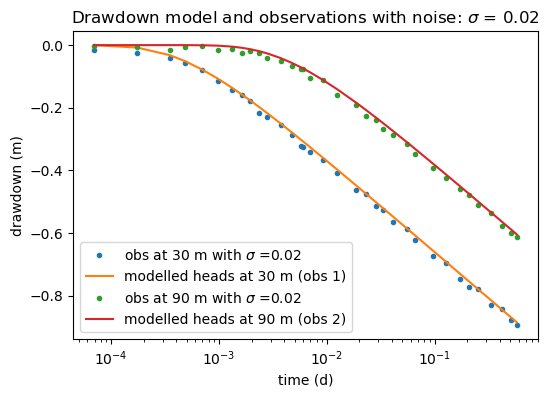

In [12]:
plt.semilogx(t, he12, ".", label="obs at 30 m with $\sigma$ =0.02")
plt.semilogx(t, h1[0], label="modelled heads at 30 m (obs 1)")
plt.semilogx(t, he22, ".", label="obs at 90 m with $\sigma$ =0.02")
plt.semilogx(t, h2[0], label="modelled heads at 90 m (obs 2)")
plt.legend()
plt.xlabel("time (d)")
plt.ylabel("drawdown (m)")
plt.title("Drawdown model and observations with noise: $\sigma$ = 0.02");

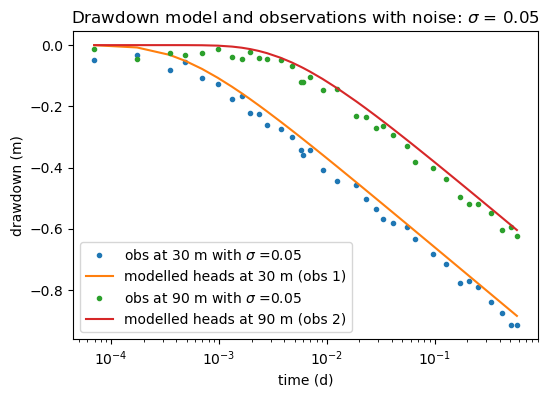

In [13]:
plt.semilogx(t, he15, ".", label="obs at 30 m with $\sigma$ =0.05")
plt.semilogx(t, h1[0], label="modelled heads at 30 m (obs 1)")
plt.semilogx(t, he25, ".", label="obs at 90 m with $\sigma$ =0.05")
plt.semilogx(t, h2[0], label="modelled heads at 90 m (obs 2)")
plt.legend()
plt.xlabel("time (d)")
plt.ylabel("drawdown (m)")
plt.title("Drawdown model and observations with noise: $\sigma$ = 0.05");

### Step 5.1: Calibration of the model using the noisy data

<a id='sig002obs1'></a>
Calibrate the model using the $\sigma $ = 0.02 noisy data from observation well 1.
* We calibrate the model by creating a `Calibrate` object with the initial model as input.
* Then we set the parameter initial values using the `set_parameter` method
* we add the observation data with the `series` method
* And fit

In [14]:
ca23 = tft.Calibrate(ml)  # class for model calibration
# Setting initial parameters values for calibration
ca23.set_parameter(name="kaq", initial=10, layers=0)  # Hydraulic Conductivity
ca23.set_parameter(name="Saq", initial=1e-3, layers=0)  # Specific Storage

ca23.series(  # Adding the observations for calibration
    name="obs1",  # Observation well 1
    x=d1,  # Location
    y=0,
    t=t,  # Time Array
    h=he12,  # Drawdown noisy data for well 1
    layer=0,  # Aquifer layer where we have the observations from
)
ca23.fit(report=True)

............................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 34
    # variables        = 2
    chi-square         = 0.00167385
    reduced chi-square = 5.2308e-05
    Akaike info crit   = -333.245645
    Bayesian info crit = -330.192924
[[Variables]]
    kaq_0_0:  70.2681207 +/- 0.41902787 (0.60%) (init = 10)
    Saq_0_0:  9.0980e-05 +/- 1.9082e-06 (2.10%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq_0_0, Saq_0_0) = -0.8544


We can already see the results from the calibration if we set `report = True` in the `fit` method. Besides fit statistics, we also get the Variables, with confidence interval and the correlations between variables during fitting process. Note that these confidence intervals can be estimated reasonably well here because the errors are random and uncorrelated, which is generally not the case for pumping tests.

We can also check the calibrated parameters:

In [15]:
ca23.parameters

,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq_0_0,0,70.268121,0.419028,0.596327,-inf,inf,10.000,None,[[70.26812066126868]]
Saq_0_0,0,0.000091,0.000002,2.097366,-inf,inf,0.001,None,[[9.097965464234536e-05]]


The `display` function returns a data frame with initial and optimal values for each parameter, besides the standard deviation of the estimate

We can now compare the model performance for both observation wells

rmse: 0.00701647184888062


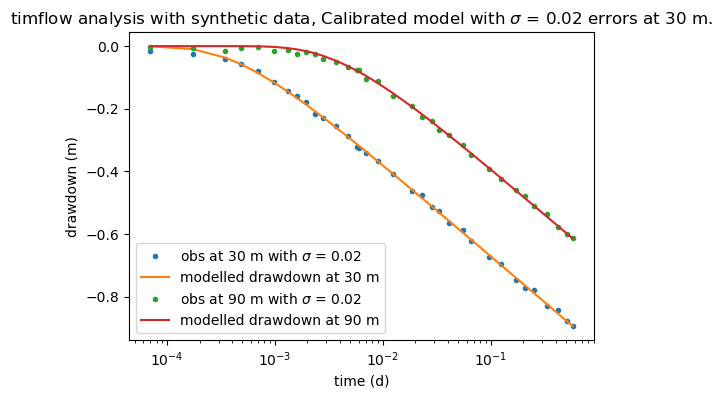

In [16]:
print("rmse:", ca23.rmse())  # Return the RMSE error for the calibration
h123 = ml.head(d1, 0, t)  # Compute drawdown of the calibrated model for obs 1
h223 = ml.head(d2, 0, t)  # Compute drawdown for obs 2
plt.semilogx(t, he12, ".", label="obs at 30 m with $\sigma$ = 0.02")
plt.semilogx(t, h123[0], label="modelled drawdown at 30 m")
plt.semilogx(t, he22, ".", label="obs at 90 m with $\sigma$ = 0.02")
plt.semilogx(t, h223[0], label="modelled drawdown at 90 m")
plt.xlabel("time (d)")
plt.ylabel("drawdown (m)")
plt.title(
    "timflow analysis with synthetic data, "
    "Calibrated model with $\sigma$ = 0.02 errors at 30 m."
)
plt.legend();

Now we do the same procedure as [before](#sig002obs1) to calibrate the model, but now using the observation data from well 2:

In [17]:
ca29 = tft.Calibrate(ml)
ca29.set_parameter(name="kaq", initial=10, layers=0)
ca29.set_parameter(name="Saq", initial=1e-3, layers=0)
ca29.series(name="obs2", x=d2, y=0, t=t, h=he22, layer=0)
ca29.fit(report=True)
display(ca29.parameters)

.....................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 34
    # variables        = 2
    chi-square         = 0.00148507
    reduced chi-square = 4.6408e-05
    Akaike info crit   = -337.314264
    Bayesian info crit = -334.261543
[[Variables]]
    kaq_0_0:  71.2273990 +/- 0.70307649 (0.99%) (init = 10)
    Saq_0_0:  8.7833e-05 +/- 2.0051e-06 (2.28%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq_0_0, Saq_0_0) = -0.8313


,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq_0_0,0,71.227399,0.703076,0.987087,-inf,inf,10.000,None,[[71.22739903738385]]
Saq_0_0,0,0.000088,0.000002,2.282844,-inf,inf,0.001,None,[[8.783289020758929e-05]]


We can once again check the model performance with the new calibrated model

rmse: 0.006608970287977903


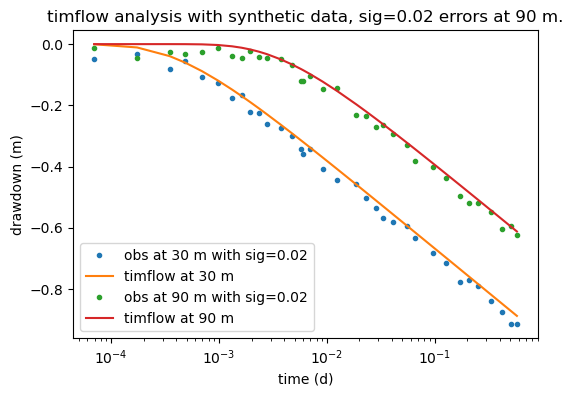

In [18]:
print("rmse:", ca29.rmse())
h129 = ml.head(d1, 0, t)
h229 = ml.head(d2, 0, t)
plt.semilogx(t, he15, ".", label="obs at 30 m with sig=0.02")
plt.semilogx(t, h129[0], label="timflow at 30 m")
plt.semilogx(t, he25, ".", label="obs at 90 m with sig=0.02")
plt.semilogx(t, h229[0], label="timflow at 90 m")
plt.legend()
plt.xlabel("time (d)")
plt.ylabel("drawdown (m)")
plt.title("timflow analysis with synthetic data, sig=0.02 errors at 90 m.")
plt.legend(loc="best");

### Step 5.2: Calibrate with two datasets simultaneously

`timflow` can also analyse the pumping tests using drawdown data from more than one borehole.

Here we calibrate the model using the data without error from both observation wells.

In [19]:
ca0 = tft.Calibrate(ml)
ca0.set_parameter(name="kaq", initial=10, layers=0)
ca0.set_parameter(name="Saq", initial=1e-3, layers=0)
ca0.series(name="obs1", x=d1, y=0, t=t, h=h1[0], layer=0)
ca0.series(name="obs2", x=d2, y=0, t=t, h=h2[0], layer=0)
ca0.fit(report=True)
display(ca0.parameters)

............................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 68
    # variables        = 2
    chi-square         = 9.4849e-15
    reduced chi-square = 1.4371e-16
    Akaike info crit   = -2478.58368
    Bayesian info crit = -2474.14466
[[Variables]]
    kaq_0_0:  69.9999989 +/- 5.8171e-07 (0.00%) (init = 10)
    Saq_0_0:  1.0000e-04 +/- 2.5194e-12 (0.00%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq_0_0, Saq_0_0) = -0.8296


,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq_0_0,0,69.999999,5.817146e-07,8.310208e-07,-inf,inf,10.000,None,[[69.99999885977871]]
Saq_0_0,0,0.000100,2.519391e-12,2.519391e-06,-inf,inf,0.001,None,[[0.00010000000247737064]]


The obtained results match exactly the input parameters

rmse: 1.1810324084799041e-08


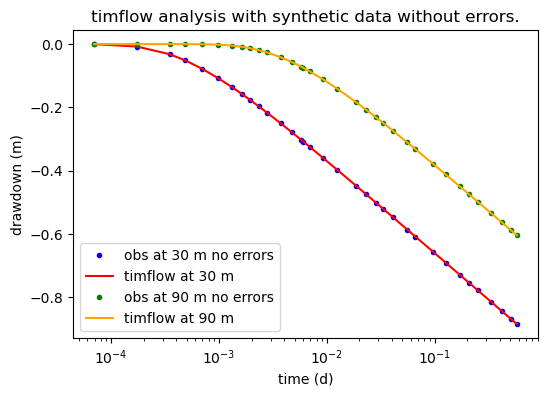

In [20]:
print("rmse:", ca0.rmse())
h1n = ml.head(d1, 0, t)
h2n = ml.head(d2, 0, t)
plt.semilogx(t, h1[0], "b.", label="obs at 30 m no errors")
plt.semilogx(t, h1n[0], color="r", label="timflow at 30 m")
plt.semilogx(t, h2[0], "g.", label="obs at 90 m no errors")
plt.semilogx(t, h2n[0], color="orange", label="timflow at 90 m")
plt.xlabel("time (d)")
plt.ylabel("drawdown (m)")
plt.title("timflow analysis with synthetic data without errors.")
plt.legend();

We do the same, but now with drawdowns with errors with $\sigma=0.02$.

In [21]:
ca2 = tft.Calibrate(ml)
ca2.set_parameter(name="kaq", initial=10, layers=0)
ca2.set_parameter(name="Saq", initial=1e-3, layers=0)
ca2.series(name="obs1", x=d1, y=0, t=t, h=he12, layer=0)
ca2.series(name="obs2", x=d2, y=0, t=t, h=he22, layer=0)
ca2.fit()
display(ca2.parameters)

.............................
Fit succeeded.


,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq_0_0,0,70.532651,0.335874,0.476197,-inf,inf,10.000,None,[[70.53265121341187]]
Saq_0_0,0,0.000090,0.000001,1.473753,-inf,inf,0.001,None,[[8.977732176160932e-05]]


rmse: 0.006892061099847132


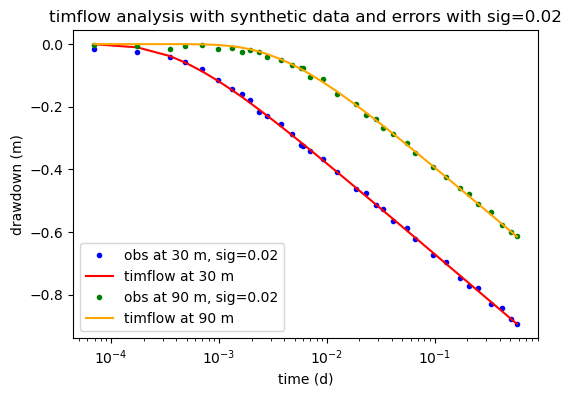

In [22]:
print("rmse:", ca2.rmse())
h12 = ml.head(d1, 0, t)
h22 = ml.head(d2, 0, t)
plt.semilogx(t, he12, "b.", label="obs at 30 m, sig=0.02")
plt.semilogx(t, h12[0], color="r", label="timflow at 30 m")
plt.semilogx(t, he22, "g.", label="obs at 90 m, sig=0.02")
plt.semilogx(t, h22[0], color="orange", label="timflow at 90 m")
plt.xlabel("time (d)")
plt.ylabel("drawdown (m)")
plt.title("timflow analysis with synthetic data and errors with sig=0.02")
plt.legend();

Drawdowns with errors with $\sigma=0.05$.

In [23]:
ca5 = tft.Calibrate(ml)
ca5.set_parameter(name="kaq", initial=10, layers=0)
ca5.set_parameter(name="Saq", initial=1e-3, layers=0)
ca5.series(name="obs1", x=d1, y=0, t=t, h=he15, layer=0)
ca5.series(name="obs2", x=d2, y=0, t=t, h=he25, layer=0)
ca5.fit()
display(ca5.parameters)

..............................
Fit succeeded.


,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq_0_0,0,71.435272,0.824493,1.154182,-inf,inf,10.000,None,[[71.4352717596985]]
Saq_0_0,0,0.000074,0.000003,3.707151,-inf,inf,0.001,None,[[7.3622073738861e-05]]


rmse: 0.017262550452917337


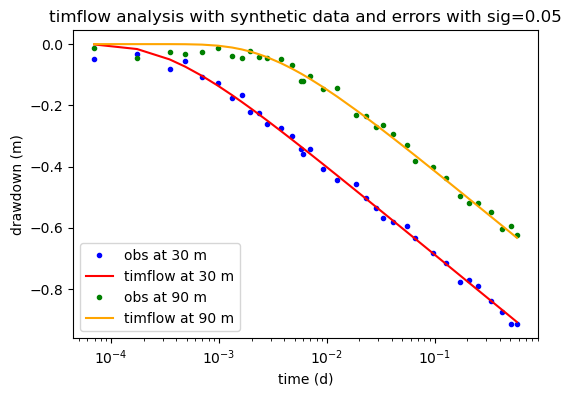

In [24]:
print("rmse:", ca5.rmse())
h15 = ml.head(d1, 0, t)
h25 = ml.head(d2, 0, t)
plt.semilogx(t, he15, "b.", label="obs at 30 m")
plt.semilogx(t, h15[0], color="r", label="timflow at 30 m")
plt.semilogx(t, he25, "g.", label="obs at 90 m")
plt.semilogx(t, h25[0], color="orange", label="timflow at 90 m")
plt.xlabel("time (d)")
plt.ylabel("drawdown (m)")
plt.title("timflow analysis with synthetic data and errors with sig=0.05")
plt.legend();

Model performed also well for $\sigma = 0.05$

## Final Remarks

In this example we have succesfully:

* Initiated a timflow model instance using the `Model` class
* Sampled observation data from the model and defined the synthetic data by adding noise.
* Calibrated the model with the `Calibrate` class using one and two calibration wells
* Inspected the calibration performance